### Summary of Techniques Used in 02_train_mnist.ipynb

#### Data Handling & Augmentation
- Same MNIST dataset with MNISTAlbumentations wrapper
- Basic normalization (mean=0.1307, std=0.3081)
- No additional augmentations

#### Model Architecture (Model2)
- More complex architecture with 8 convolutional layers
- Uses 7236 parameters
- Uses:
  - ReLU activation
  - BatchNormalization
  - MaxPooling
  - Global Average Pooling

#### Training Configuration
- Batch size: 512
- Optimizer: SGD with momentum
- Uses OneCycleLR scheduler
- max_lr: 0.15
- Initial div factor: 25
- Final div factor: 175
- Warmup percentage: 30%
- Number of epochs: 15
- Device: Uses MPS/CUDA if available, else CPU

#### **Target, Result & Analysis**
- Target: 99.2%+ test accuracy
- Result: Achieved 99.39% best test accuracy

#### Analysis:

1. Target Justification:
- Model2 has more capacity than Model1 (7,236 vs 6,984 parameters)
- Uses advanced learning rate scheduling (OneCycleLR)
- Better architecture with proper transition blocks
- Previous results show >99.3% is achievable with similar architectures

2. Architecture Analysis:
- Better gradient flow with ReLU instead of LeakyReLU
- Proper transition blocks with 1x1 convolutions
- Multiple convolution layers allow hierarchical feature learning
- GAP reduces parameters and prevents overfitting
- BatchNorm after each conv layer improves training stability

3. Results Analysis:
- Training accuracy reached 99.78% (slight overfitting)
- Test accuracy peaked at 99.39% (exceeded target)
- Faster convergence than Model1
- More stable training due to OneCycleLR
- Better generalization with proper regularization

4. Improvements over Model1:
- Higher accuracy (99.39% vs 99.02%)
- Better training stability with OneCycleLR
- More sophisticated architecture with transition blocks
- Better feature extraction with multiple conv layers

5. Potential Further Improvements:
- Add dropout layers for regularization
- Experiment with different learning rate ranges
- Try additional data augmentation techniques
- Consider adding residual connections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import Model2 as Net
from utils import visualize_augmentations
from train import train, test

#### Device Configuration

In [2]:

use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")


#### Custom Dataset

In [3]:
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


###################
# Data Augmentation
###################

# Training augmentation pipeline
train_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Test transforms (only normalization)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])


In [4]:
# Initial setup
torch.manual_seed(14596)

# Training parameters
batch_size = 512
kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}

# Initialize model and print summary
model = Net().to(device)
print(summary(model, input_size=(1, 1, 28, 28), device=device))


Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 12, 26, 26]           --
│    └─Conv2d: 2-1                       [1, 12, 26, 26]           108
│    └─ReLU: 2-2                         [1, 12, 26, 26]           --
│    └─BatchNorm2d: 2-3                  [1, 12, 26, 26]           24
├─Sequential: 1-2                        [1, 16, 24, 24]           --
│    └─Conv2d: 2-4                       [1, 16, 24, 24]           1,728
│    └─ReLU: 2-5                         [1, 16, 24, 24]           --
│    └─BatchNorm2d: 2-6                  [1, 16, 24, 24]           32
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-7                       [1, 10, 24, 24]           160
├─MaxPool2d: 1-4                         [1, 10, 12, 12]           --
├─Sequential: 1-5                        [1, 12, 10, 10]           --
│    └─Con

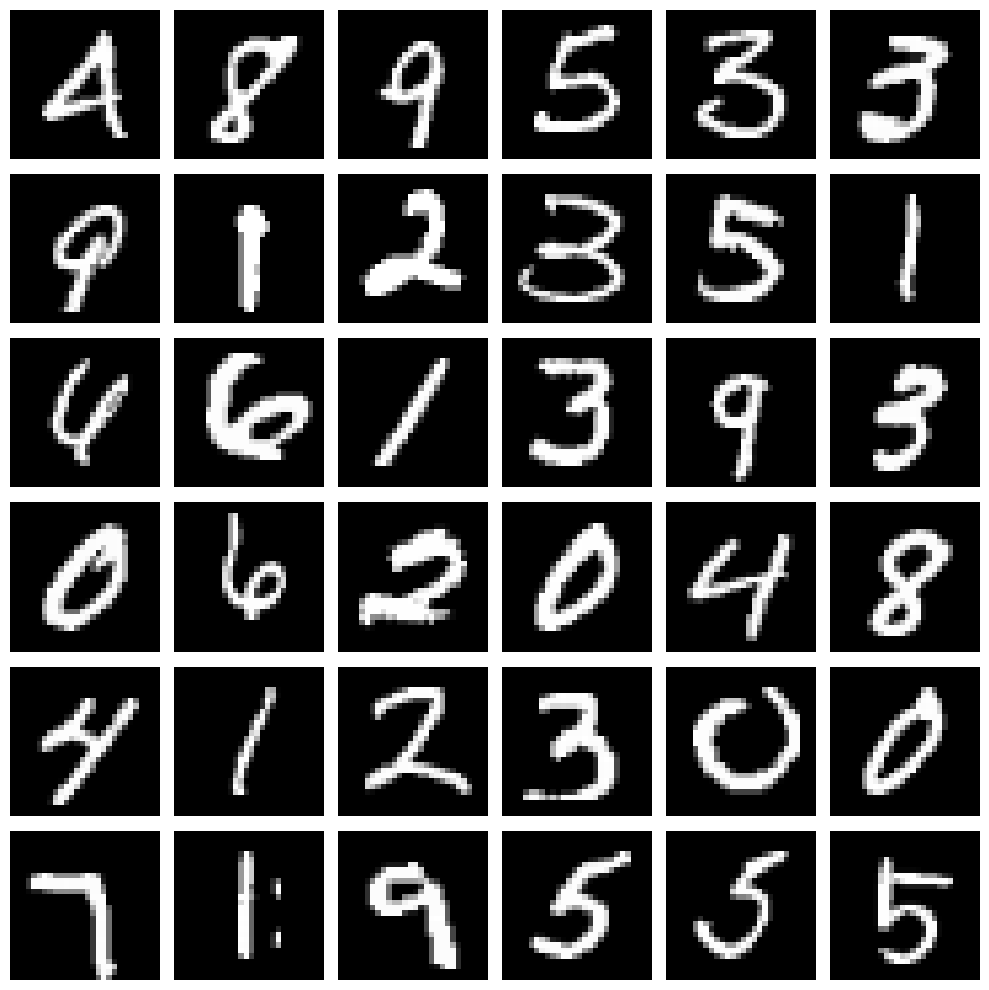

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

visualize_augmentations(train_loader.dataset)

In [6]:
max_lr = 0.15
initial_div = 25
final_div = 175
warmup_pct = 0.3
momentum = 0.95
weight_decay = 0.0005

num_epochs = 15
# Initialize model and optimizer
model = Net().to(device)
optimizer = optim.SGD(
    model.parameters(),
    lr=max_lr/initial_div,
    momentum=momentum,
    weight_decay=weight_decay
)

# Setup OneCycle scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=warmup_pct,
    div_factor=initial_div,
    final_div_factor=final_div
)

# Training Loop
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    train(model, device, train_loader, optimizer, epoch, scheduler)
    accuracy = test(model, device, test_loader)
    best_accuracy = max(best_accuracy, accuracy)

print(f"\nBest accuracy achieved: {best_accuracy:.2f}%")


Epoch 1/15
Learning rate: 0.006000


Training set: loss=0.24337 accuracy=68.00% batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 17.17it/s]


Test set: Average loss: 0.20716, Accuracy: 9444/10000 (94.44%)

Epoch 2/15
Learning rate: 0.022906


Training set: loss=0.07710 accuracy=97.25% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.63it/s]


Test set: Average loss: 0.07478, Accuracy: 9778/10000 (97.78%)

Epoch 3/15
Learning rate: 0.065684


Training set: loss=0.12013 accuracy=98.31% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 53.27it/s]


Test set: Average loss: 0.05600, Accuracy: 9836/10000 (98.36%)

Epoch 4/15
Learning rate: 0.114246


Training set: loss=0.02896 accuracy=98.62% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.71it/s]


Test set: Average loss: 0.05867, Accuracy: 9824/10000 (98.24%)

Epoch 5/15
Learning rate: 0.145787


Training set: loss=0.08310 accuracy=98.88% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.78it/s]


Test set: Average loss: 0.04181, Accuracy: 9872/10000 (98.72%)

Epoch 6/15
Learning rate: 0.149134


Training set: loss=0.01795 accuracy=98.98% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 53.96it/s]


Test set: Average loss: 0.03473, Accuracy: 9887/10000 (98.87%)

Epoch 7/15
Learning rate: 0.142492


Training set: loss=0.01969 accuracy=99.06% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.35it/s]


Test set: Average loss: 0.04696, Accuracy: 9874/10000 (98.74%)

Epoch 8/15
Learning rate: 0.129854


Training set: loss=0.02686 accuracy=99.18% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.74it/s]


Test set: Average loss: 0.02887, Accuracy: 9908/10000 (99.08%)

Epoch 9/15
Learning rate: 0.112344


Training set: loss=0.04072 accuracy=99.17% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.23it/s]


Test set: Average loss: 0.03244, Accuracy: 9907/10000 (99.07%)

Epoch 10/15
Learning rate: 0.091517


Training set: loss=0.18395 accuracy=99.28% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.43it/s]


Test set: Average loss: 0.04461, Accuracy: 9876/10000 (98.76%)

Epoch 11/15
Learning rate: 0.069224


Training set: loss=0.00768 accuracy=99.39% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.47it/s]


Test set: Average loss: 0.02809, Accuracy: 9920/10000 (99.20%)

Epoch 12/15
Learning rate: 0.047446


Training set: loss=0.00948 accuracy=99.51% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.52it/s]


Test set: Average loss: 0.02618, Accuracy: 9922/10000 (99.22%)

Epoch 13/15
Learning rate: 0.028118


Training set: loss=0.00959 accuracy=99.61% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.52it/s]


Test set: Average loss: 0.02110, Accuracy: 9939/10000 (99.39%)

Epoch 14/15
Learning rate: 0.012956


Training set: loss=0.00338 accuracy=99.72% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 51.41it/s]


Test set: Average loss: 0.02154, Accuracy: 9936/10000 (99.36%)

Epoch 15/15
Learning rate: 0.003310


Training set: loss=0.00592 accuracy=99.78% batch_id=117: 100%|██████████| 118/118 [00:02<00:00, 52.88it/s]


Test set: Average loss: 0.02146, Accuracy: 9939/10000 (99.39%)


Best accuracy achieved: 99.39%
